In [ ]:
!nvidia-smi

Thu May 11 10:27:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q --upgrade transformers diffusers ftfy huggingface_hub
!pip install -q accelerate 
!pip install -q einops
!pip install -q gradio
!pip install -q open_clip_torch
!pip install -q --upgrade omegaconf
!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 11.0 MB/s eta 0:0

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
import os
from PIL import Image
import numpy as np
import albumentations as A
import albumentations.pytorch as AP
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from base64 import b64encode
import numpy as np
import json
import cv2
# from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
import subprocess

# For video display:
from IPython.display import HTML
from pathlib import Path
from torch import autocast
from torchvision import transforms as tfms
import pytorch_lightning as pl
from transformers import logging #CLIPTextModel, CLIPTokenizer, 
from transformers import BlipProcessor, BlipForConditionalGeneration

# torch.manual_seed(1)

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

from huggingface_hub import hf_hub_download
from diffusers import DiffusionPipeline
from huggingface_hub import notebook_login

In [ ]:
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Copying the code from github to colab
os.chdir('/content/')
# !git clone https://github.com/lllyasviel/ControlNet.git
!git clone https://github.com/anilbhatt1/ControlNet.git 
%cd '/content/ControlNet'
! ls

Cloning into 'ControlNet'...
remote: Enumerating objects: 1398, done.
remote: Counting objects: 100% (483/483), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1398 (delta 423), reused 415 (delta 396), pack-reused 915
Receiving objects: 100% (1398/1398), 122.40 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (635/635), done.
/content/ControlNet
annotator			      gradio_scribble2image.py
cldm				      gradio_seg2image.py
config.py			      ldm
docs				      LICENSE
environment.yaml		      models
font				      README.md
github_page			      share.py
gradio_annotator.py		      test_imgs
gradio_canny2image.py		      tool_add_control.py
gradio_depth2image.py		      tool_add_control_sd21.py
gradio_fake_scribble2image.py	      tool_transfer_control.py
gradio_hed2image.py		      tutorial_dataset.py
gradio_hough2image.py		      tutorial_dataset_test.py
gradio_normal2image.py		      tutorial_train.py
gradio_pose2image.py		      tutorial_train_sd21.py
gradio_scribble2image_inte

##Dataset creation for Canny

In [ ]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/ThumbnailData.zip', mode='r') as input:
  input.extractall('/content')

CPU times: user 1.25 s, sys: 963 ms, total: 2.21 s
Wall time: 2.36 s


In [ ]:
# Retaining images only in Flying Birds folder
!rm -rf '/content/Data/Winged Drones'
!rm -rf '/content/Data/Large QuadCopters'
!rm -rf '/content/Data/Small QuadCopters'

In [ ]:
dir_path = '/content/Data/Flying Birds'
file_list = os.listdir(dir_path)
len(file_list)

7574

In [ ]:
file_list[0:5], file_list[-5:]

(['img01735.jpg',
  'img04114.jpg',
  'img02602.jpg',
  'img00553.jpg',
  'img03017.jpg'],
 ['img05433.jpg',
  'img02161.jpg',
  'img06044.jpg',
  'img07009.jpg',
  'img03055.jpg'])

In [ ]:
img_name = file_list[-1]
img_path = f'/content/Data/Flying Birds/{img_name}'
img_path

'/content/Data/Flying Birds/img03055.jpg'

####Caption generation

In [ ]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

In [ ]:
img_dict = {}
for idx, img_name in enumerate(file_list):
    img_path = f'/content/Data/Flying Birds/{img_name}'
    raw_image = Image.open(img_path)
    # unconditional image captioning
    inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)
    out = model.generate(**inputs)
    caption = str(processor.decode(out[0], skip_special_tokens=True))
    img_dict[img_name] = caption
    if idx%500 ==0:
       print(f'{idx} - {img_name} - {caption}')
print(len(img_dict), img_dict['img02161.jpg'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


0 - img01735.jpg - a bird flying in the sky
500 - img05475.jpg - a bird flying in the sky
1000 - img02001.jpg - a bird flying in the sky
1500 - img00698.jpg - a bird flying in the sky
2000 - img00763.jpg - a humming flying in the air with its wings spread
2500 - img06658.jpg - a white bird flying
3000 - img02646.jpg - a hummingbird flying in the air
3500 - img06689.jpg - a white bird flying in the sky
4000 - img05477.jpg - a bird flying in the sky
4500 - img03836.jpg - a bird flying in the sky
5000 - img01122.jpg - a bird is flying over a dead animal
5500 - img07470.jpg - a bird flying over the ocean
6000 - img00494.jpg - a large body of water
6500 - img00057.jpg - a bird flying in the sky
7000 - img06820.jpg - two birds flying over a branch
7500 - img05656.jpg - a white bird with a yellow crown on its head
7574 a white bird flying in the sky


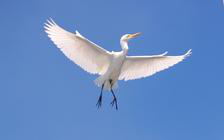

In [ ]:
Image.open('/content/Data/Flying Birds/img02161.jpg')

In [ ]:
with open('/content/image_dict.txt', 'w') as f:
    # write each key-value pair in the dictionary to the file
    for key, value in img_dict.items():
        f.write('{"source": '+ '"'+str(key)+'"' + ', ' + '"target": '+ '"'+str(key)+'"' + ', ' + '"prompt": ' + '"'+str(value)+'"}' + '\n')

####Generate canny image

In [ ]:
from diffusers.utils import load_image

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!rm -rf '/content/Data/canny_flying_birds'

In [ ]:
!mkdir '/content/Data/canny_flying_birds'

In [ ]:
out_path = f'/content/Data/canny_flying_birds'
for idx, img_name in enumerate(file_list):
    img_path = f'/content/Data/Flying Birds/{img_name}'
    image = Image.open(img_path)
    image = np.array(image)

    low_threshold = 100
    high_threshold = 200

    image = cv2.Canny(image, low_threshold, high_threshold)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    canny_image = Image.fromarray(image)
    out_file_name = f'{out_path}/{img_name}'
    canny_image.save(out_file_name)
    if idx%750 ==0:
       print(idx, out_file_name)

0 /content/Data/canny_flying_birds/img01735.jpg
750 /content/Data/canny_flying_birds/img04338.jpg
1500 /content/Data/canny_flying_birds/img00698.jpg
2250 /content/Data/canny_flying_birds/img01826.jpg
3000 /content/Data/canny_flying_birds/img02646.jpg
3750 /content/Data/canny_flying_birds/img00088.jpg
4500 /content/Data/canny_flying_birds/img03836.jpg
5250 /content/Data/canny_flying_birds/img00027.jpg
6000 /content/Data/canny_flying_birds/img00494.jpg
6750 /content/Data/canny_flying_birds/img03247.jpg
7500 /content/Data/canny_flying_birds/img05656.jpg


In [ ]:
img_dict['img05656.jpg']

'a white bird with a yellow crown on its head'

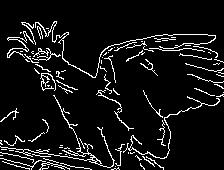

In [ ]:
Image.open('/content/Data/canny_flying_birds/img05656.jpg')

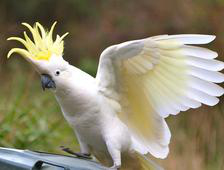

In [ ]:
Image.open('/content/Data/Flying Birds/img05656.jpg')

In [ ]:
!zip -rq '/content/canny_data.zip' '/content/Data'

In [ ]:
!cp '/content/canny_data.zip' '/content/gdrive/MyDrive/EVA8_P1_S15'

##Preparing dataloader 

In [ ]:
os.chdir('/content/')
!cp -r '/content/gdrive/MyDrive/EVA8_P1_S15' '.'
!pwd

/content


In [ ]:
os.chdir('/content')
!pwd
!unzip -q '/content/EVA8_P1_S15/flyingbirds.zip'
!ls '/content/flyingbirds/source' | wc -l
!ls '/content/flyingbirds/target' | wc -l

/content
7574
7574


In [ ]:
class MyDataset(Dataset):
    def __init__(self):
        self.data = []
        with open('/content/flyingbirds/prompt.json', 'rt') as f:
            for line in f:
                self.data.append(json.loads(line))
        self.width = 512
        self.height = 512

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        source_filename = item['source']                
        target_filename = item['target']
        prompt = item['prompt']

        source = cv2.imread('/content/flyingbirds/source/' + source_filename)
        target = cv2.imread('/content/flyingbirds/target/' + target_filename)

        source = cv2.resize(source, (self.width, self.height), interpolation=cv2.INTER_NEAREST)
        target = cv2.resize(target, (self.width, self.height), interpolation=cv2.INTER_NEAREST)

        # Do not forget that OpenCV read images in BGR order.
        source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        # Normalize source images to [0, 1].
        source = source.astype(np.float32) / 255.0

        # Normalize target images to [-1, 1].
        target = (target.astype(np.float32) / 127.5) - 1.0

        return dict(jpg=target, txt=prompt, hint=source)

In [ ]:
dataset = MyDataset()
print(len(dataset))

item = dataset[234]
jpg = item['jpg']
txt = item['txt']
hint = item['hint']
print(txt)
print(jpg.shape)
print(hint.shape)

7574
a flock of birds flying in the sky
(512, 512, 3)
(512, 512, 3)


##Training Canny from scratch

In [ ]:
os.chdir('/content/ControlNet')

In [ ]:
from cldm.logger import ImageLogger
from cldm.model import create_model, load_state_dict

# resume_path = '/content/models/control_sd15_ini.ckpt'
# resume_path = '/content/gdrive/MyDrive/EVA8_P1_S15_CTLNET_Wt/epoch=1-step=1894.ckpt'
batch_size = 8
logger_freq = 315
learning_rate = 1e-5
sd_locked = True
only_mid_control = False

# First use cpu to load models. Pytorch Lightning will automatically move it to GPUs.
model = create_model('./models/cldm_v15.yaml').cpu()
# model.load_state_dict(load_state_dict(resume_path, location='cpu'))
model.learning_rate = learning_rate
model.sd_locked = sd_locked
model.only_mid_control = only_mid_control

create_model-config : {'model': {'target': 'cldm.cldm.ControlLDM', 'params': {'linear_start': 0.00085, 'linear_end': 0.012, 'num_timesteps_cond': 1, 'log_every_t': 200, 'timesteps': 1000, 'first_stage_key': 'jpg', 'cond_stage_key': 'txt', 'control_key': 'hint', 'image_size': 64, 'channels': 4, 'cond_stage_trainable': False, 'conditioning_key': 'crossattn', 'monitor': 'val/loss_simple_ema', 'scale_factor': 0.18215, 'use_ema': False, 'only_mid_control': False, 'control_stage_config': {'target': 'cldm.cldm.ControlNet', 'params': {'image_size': 32, 'in_channels': 4, 'hint_channels': 3, 'model_channels': 320, 'attention_resolutions': [4, 2, 1], 'num_res_blocks': 2, 'channel_mult': [1, 2, 4, 4], 'num_heads': 8, 'use_spatial_transformer': True, 'transformer_depth': 1, 'context_dim': 768, 'use_checkpoint': True, 'legacy': False}}, 'unet_config': {'target': 'cldm.cldm.ControlledUnetModel', 'params': {'image_size': 32, 'in_channels': 4, 'out_channels': 4, 'model_channels': 320, 'attention_resolu

Loaded model config from [./models/cldm_v15.yaml]


In [ ]:
# Misc
dataset = MyDataset()
dataloader = DataLoader(dataset, num_workers=0, batch_size=batch_size, shuffle=True)
logger = ImageLogger(batch_frequency=logger_freq)
trainer = pl.Trainer(precision=32, callbacks=[logger], max_epochs=10)

# Train!
trainer.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('global_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.95it/s]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
!cp -r '/content/ControlNet/lightning_logs/version_0/checkpoints/epoch=9-step=9470.ckpt' '/content/gdrive/MyDrive/EVA8_S15_May11'

In [ ]:
!cp -r '/content/ControlNet/image_log' '/content/gdrive/MyDrive/EVA8_S15_May11'

In [ ]:
!rm -rf '/content/gdrive/MyDrive/EVA8_S15_May11/image_log/train/train'